# Тeматическое моделирование

В этом ноутбуке я покажу, как работает тематическое моделирование (topic modeling) на примере корпуса новостей с сайта Lenta.ru.

**Что это такое:**
"Тематическое моделирование — способ построения модели коллекции текстовых документов, которая определяет, к каким темам относится каждый из документов" [Википедия](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

**Зачем?**
Тематическое моделирование позволяет автоматически выделить основные темы в корпусе текстов (наборе документов); ключевые слова, соответствующие каждой теме, и распределение тем над документами. Т.е. для каждого документа будет получен набор чисел, насколько данный документ принадлежит той или иной теме. 

В этом ноутбуке я буду использовать открытый датасет, который состоит из новостей с сайта Lenta.ru. Если хотите самостоятельно выполнить пример, то скачайте этот [датасет](https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2) и распакуйте его в папку с этой тетрадкой.

Существует несколько алгоритмов для тематического моделирования. Мы рассмотрим один из самых базовых - LDA (Latent Dirichle Allocation). А более продвинутые алгоритмы ищете на 

In [1]:
import re

import pandas as pd
import numpy as np
import json
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

SEED = 42

# EDA

In [2]:
df = pd.read_csv("../datasets/post_lemmatized.csv", index_col=0)
df.head()

,user_id,post,post_lemmatized,likes,comments,reposts,hashtags
0,ali-wodan,Кстати говоря. Теперь подкаст Миражи доступен в соцсети Вконтакте: https://lnkd.in/gKkrJX9Я наконец разобрался как туда прикрутить RSS :-) #podcast #миражи,говоря подкаст мираж доступный соцсеть вконтакте разобраться прикрутить,1,0,0,"podcast, миражи"
1,ali-wodan,"Хэй честной народ! Ищу векторного иллюстратора на проект, с возможным длительным сотрудничеством по итогу. Можно удаленно. Уровень иллюстраций не хуже чем в примере https://lnkd.in/gkrvhxYРепост, пожалуйста)Если ты умеешь так рисовать, напиши мне в личку :-)Hey! I am looking for an Illustrator who can help us with a project! You need to have skills like in the example below or upper. Text me to discuss prices and due :-)#вакансия #vacancy #illustration #иллюстрация #project #проект",честной народ искать векторный иллюстратор проект возможный длительный сотрудничество итогу удаленно уровень иллюстрация пример репост ести уметь рисовать написать личка,6,0,0,"вакансия, vacancy, illustration, иллюстрация, project, проект"
2,ali-wodan,"Новый пост подкаста ""Миражи"" на всех платформах:В аудио: https://lnkd.in/giWuSVNВ инстаграме: https://lnkd.in/gbV6yxKН #automotive # # #cars #а патреоне: https://lnkd.in/gfShqTU#саморазвитие #психология #психологиячеловека #психологияжизни #психологияличности #личностныйрост #подкаст #подкастмиражи #маркетинг #осознанность #мысли #мысливслух #установки #влияние #подсознаниеИспользованные звуки, музыка и картинки:Аудиоцитата из фильма ""Формула любви"" Марка ЗахароваJardins du Luxembourg by Jahzzar is licensed under a Attribution-ShareAlike 3.0 International License.prisoner by Luis Prado from the Noun Project",пост подкаст миражи платформах аудио инстаграме патреоне звуки музыка картинки аудиоцитат фильм формула любви марк захарова,1,0,0,"automotive, cars, а, саморазвитие, психология, психологиячеловека, психологияжизни, психологияличности, личностныйрост, подкаст, подкастмиражи, маркетинг, осознанность, мысли, мысливслух, установки, влияние, подсознаниеИспользованные"
3,ali-wodan,"Подкаст Миражи, Эпизод 13Ошибка невозвратных затратpodcast.ru/1539345144#подкаст #podcast #it #podcasts #psychology #психология #miragespodcast",подкаст миражи эпизод ошибка невозвратный затрат,2,0,0,"подкаст, podcast, it, podcasts, psychology, психология, miragespodcast"
4,ali-wodan,Новый эпизод об эффекте ИКЕА на всех платформах podcast.ru/1539345144,эпизод эффект икеа платформа,1,0,0,NaN


Наш датасет уже токенизирован и лематизирован. Все равно преведем небольшой анализ.

In [3]:
df.shape

(2264, 7)

In [4]:
# число дублей
df.post_lemmatized.duplicated().sum()

105

Возможно это сообщения рекламного характера. Посмотрим на эти сообщения.

In [5]:
df[df.post_lemmatized.duplicated(keep=False)].post_lemmatized

76                                                                                                                                                                                                                                                                                                                                                                                                                                                                               знать людей заинтересовать
82                                                                                                                                                                                                                      настоящий время находиться поиск карьерный возможностей горизонт вызовов благодарить оказать поддержку выражаться форма рекомендация контактов совет возможностей предложить вкратце иметь опыт сфера составлять непрерывный опыт рекрутинг хантинга резюме готовый направить личку
263             

In [6]:
# удалим дубли
df = df.drop_duplicates(subset='post_lemmatized', ignore_index=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          2159 non-null   object
 1   post             2159 non-null   object
 2   post_lemmatized  2159 non-null   object
 3   likes            2159 non-null   int64 
 4   comments         2159 non-null   int64 
 5   reposts          2159 non-null   int64 
 6   hashtags         1371 non-null   object
dtypes: int64(3), object(4)
memory usage: 118.2+ KB


Оценим размеры постов в количестве символов и количестве слов.

In [8]:
# подсчет числа символов
def count_chars(text):
    return(len(text))

# подсчет числа слов
def count_words(text):
    return(len(text.split()))

In [9]:
df['num_chars'] = df.post_lemmatized.apply(count_chars)
df['num_words'] = df.post_lemmatized.apply(count_words)

Всего в датасете чуть более 2 тыс. постов. Для каждого есть автор (user_id), содержание (post_lemmatized) и реакции (likes, comments, reposts). Не у всех пользователей указаны хештеги.

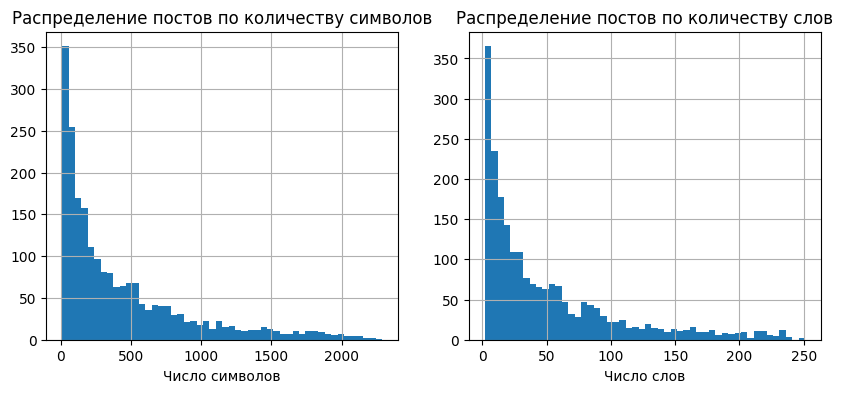

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df.num_chars.hist(bins=50)
plt.title('Распределение постов по количеству символов'), plt.xlabel('Число символов')
plt.subplot(1, 2, 2)
df.num_words.hist(bins=50)
plt.title('Распределение постов по количеству слов'), plt.xlabel('Число слов');

In [11]:
df.tail(3)

,user_id,post,post_lemmatized,likes,comments,reposts,hashtags,num_chars,num_words
2156,elminaliev,"Один из главных инсайтов, что я понял и осознал к своим 26 годам. Слова Сократа. Популярные, да, но недостаточно их просто знать. Пока они не станут частью жизни, они бессмысленны.",главный инсайтов понять осознать годам слово сократа популярные недостаточно знать стать часть жизни бессмысленны,7,0,0,NaN,113,14
2157,elminaliev,"Впервые спустя 4 месяца вернулся к силовым тренировкам. В принципе это был медленный путь возвращения: сначала тренировки пресса и растяжка (в апреле), чтобы вспомнить, что такое нагрузка после того, как мозг решил, что надо «отдохнуть» в феврале; затем кардио тренировки на пульсе 110, а сейчас наконец силовые тренировки в умеренном темпе и с максимально правильным дыханием Мораль, которую я для себя вывел, — всё должно быть постепенно. наскоком ничего не возьмешь: ни один город, ни один разум, ни одну цель. Всё начинается с нуля. Хоть и сложно начинать с нуля, но необходимо. После февраля я не знал, когда вернусь полноценно к тренировкам и вернусь ли, потому что сердечно-сосудистая и нервная системы не чувствовали себя на 100%. Да и сейчас не в идеальном состоянии, но я на нужном пути. Возвращаюсь. Это лето для всех как лето: отдых, арбузы, загар, посиделки с шашлыками. Для меня будет летом, чтобы вернуться на прежний уровень физически и работать над ментальной составляющей The obstacle is the way",впервые спустя вернуться силовой тренировкам принцип медленный путь возвращения сначала тренировка пресса растяжка апреле вспомнить нагрузка мозг решил отдохнуть феврале затем кардио тренировка пульс силовой тренировка умеренный темп максимально правильный дыхание мораль вывел должный постепенно наскоком возьмешь разум цель начинаться нуля сложно начинать нуля необходимо знал вернуться полноценно тренировка вернуться сердечно сосудистый нервный система чувствовать идеальный состоянии нужный пути возвращаюсь лето лето отдых арбузы загар посиделки шашлыками летом вернуться прежний уровень физически работать ментальный составлять,2,0,0,NaN,634,75
2158,elminaliev,Рассказал в своём телеграм канале об опыте съёмок для Самоката и почему хочу выступить в Лондоне. Check it out,рассказать телеграм канал опыт съёмка самокат почему выступить лондоне,2,0,0,NaN,70,9


In [12]:
# характеристики постов по символам
df.num_chars.describe()

count    2159.000000
mean      438.035201
std       477.541175
min         9.000000
25%        86.000000
50%       250.000000
75%       620.000000
max      2290.000000
Name: num_chars, dtype: float64

In [13]:
# характеристики постов по словам
df.num_words.describe()

count    2159.000000
mean       49.678092
std        54.012155
min         2.000000
25%        10.000000
50%        29.000000
75%        70.000000
max       251.000000
Name: num_words, dtype: float64

Большая часть постов короткие. Медианный размер поста 250 символов 29 слов. Наверно есть смысл отбросить посты попадающие в 1 квартиль по числу символов и слов.

In [14]:
q1_chars = round(df.num_chars.quantile(0.25))
q1_words = round(df.num_words.quantile(0.25))
q1_chars, q1_words

(86, 10)

In [15]:
# оценка мелких текстов
df.query('num_chars < @q1_chars and num_words < @q1_words').post_lemmatized.head()

0     говоря подкаст мираж доступный соцсеть вконтакте разобраться прикрутить
3                            подкаст миражи эпизод ошибка невозвратный затрат
4                                                эпизод эффект икеа платформа
7                                                            эпизод платформа
10              эпизод подкаст говорить парапланеризм совмещаться работа айти
Name: post_lemmatized, dtype: object

In [16]:
# оценка медианных текстов
df.query('num_chars == 250 or num_words == 29').post_lemmatized.head()

122                       прочитать хабра отличный материал слить карьера системный аналитика деле статья системный аналитика вообще любой разумный человека ценный перечислить важный софт скилы добавить ссылка материал советами подтянуть общем искренне рекомендую
159                                           девочка девушки пусть весна сердце душе пусть марта каждый хотеться петь танцевать гулять наслаждаться жизнью пусть мужчина позволять хрупкий нежными дарить ласка заботу носить рука всячески жизнь счастливее прекрасны
278               работать киый нии вернадского отдел котоырть совместно китайский учёный заниматься разработка оконный стёкол цель минимизация потеря тепло окна сделать оптически прозрачный прототип аккумулировать солнечный энергия вечером отдавать вовнутрь дома
337    короновирус рецессия мировой экономики сокращения увольнения давать взглянуть стороны кризис начало нового думаете возрасти кол стартапов именно стоить находить единомышленник запираться гараж энергети

In [17]:
# оценка больших текстов
df.query('num_chars >= 620 and num_words >= 70').post_lemmatized.head(3)

14    классный коллега команда редизайн развитие отдельный продукт промо сайт продукт сложный веб приложение сопровождениеили веб приложение основа дизайн системыразработка поддержка кроссплатформенный дизайн системымаркетинговый задачи лэндинги письма оптимизация конверсия сайтовконтроль качество ожидаем опыт разработка интерфейс студия продуктовый компания летминимум живой проект дизайн сети минимум сложныйумение желание вникать разбираться умение думать основной инструмент возможный время перейти фигма точно умение работать понадобиться предлагаем белый заработный платакомфортный офис минута ходьба тульскаяспортзал настольный теннис занятие тренером группа английский китайский язык офисесовременный удобный рабочий место мощный маки мониторыдмс испытательный срок вопрос отклик писать почта телеграм
19                                                                                                                                                                                        ка

In [18]:
# удалаяем короткие посты
df = df.query('num_chars >= @q1_chars and num_words >= @q1_words')

In [19]:
# оценка датасета после фильтрации
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 1 to 2157
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          1615 non-null   object
 1   post             1615 non-null   object
 2   post_lemmatized  1615 non-null   object
 3   likes            1615 non-null   int64 
 4   comments         1615 non-null   int64 
 5   reposts          1615 non-null   int64 
 6   hashtags         1083 non-null   object
 7   num_chars        1615 non-null   int64 
 8   num_words        1615 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 126.2+ KB


Наш датасет сократился на четверть.

# Моделирование

## Подготовка текстов

Складываем все тексты в один список.

In [20]:
docs = df["post_lemmatized"].tolist()

In [21]:
# первые пять элементов
docs[:5]

['честной народ искать векторный иллюстратор проект возможный длительный сотрудничество итогу удаленно уровень иллюстрация пример репост ести уметь рисовать написать личка',
 'пост подкаст миражи платформах аудио инстаграме патреоне звуки музыка картинки аудиоцитат фильм формула любви марк захарова',
 'редкий случай считать правильный распространять призыв проявить активный позиция вмешаться политический жизнь государства подсказывает поправка пройдут творчество просветительство оказаться угроза снг конкретно идти речь подробно описать попов видео',
 'снова искать классный коллега команда нужны уверенный мидло продакт дизайнер основный линейка продукт работы маркетинг мать работы скил юай юикс райтер привести порядок интерфейсный тексты нужный английский прекрасный русский опыт работа способность глубоко разбираться технический деталь переводить айтишный человеческий условие классноподробности вилка зп подробный условие телеграм почта',
 'заказчик сколько нужно время дизайн проекта диз

## Векторизация текстов

Теперь необходимо перевести тексты и слова, из которых они состоят, в числовое представление, т.е. провести векторизацию. Для этого можно используем метод Tf-iDf.

In [22]:
# создаем модель векторизации
tfidf = TfidfVectorizer(min_df=9, max_df=0.9)

In [23]:
%%time
# обучим модель и получим векотрное представление для каждого текста
x = tfidf.fit_transform(docs)

CPU times: total: 188 ms
Wall time: 190 ms


In [25]:
# размер полученной матрицы
x.shape

(1615, 1945)

Теперь составим словарь {id_токена: токен} - он пригодится нам позднее.

In [26]:
# список слов векторизатора
tfidf.get_feature_names_out()

array(['абсолютно', 'автоматизация', 'автоматизированный', ..., 'языком',
       'яндекс', 'яркий'], dtype=object)

In [27]:
# словарь
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

In [28]:
# примеры слов в словаре
id2word[0], id2word[1], id2word[2], id2word[1000], id2word[1761]

('абсолютно', 'автоматизация', 'автоматизированный', 'память', 'тяжело')

## LDA

Теперь можем запустить алгоритм LDA. Зададим количество тем равное 15.

In [29]:
# число тем
n_topics = 10

In [30]:
# создаем модель
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=120,
    batch_size=64,
    random_state=SEED
)

In [31]:
%%time
# обучаем модель на матрице векторизированных текстов
topics = lda.fit_transform(x)

CPU times: total: 45.1 s
Wall time: 45.3 s


In [32]:
# метрика показывает приблизительное логарифмическое правдоподобие
lda.score(x)

-75023.94427893005

In [33]:
# рамер полученной матрицы
topics.shape

(1615, 10)

Получили массив размера 1564x15. Строки здесь - отдельные тексты, а колонки - 15 выделенных тем. В каждой ячейке стоит вероятность того, что данный текст относится к данной теме. Это то самое распределение тем над документами.

In [34]:
# оценим вероятности пренадлежности первых 5 текстов к топикам
topics[:5]

array([[0.02211703, 0.02211784, 0.02211703, 0.0221259 , 0.02211706,
        0.02211704, 0.02211703, 0.80093425, 0.0221197 , 0.02211711],
       [0.03365759, 0.03365759, 0.69707213, 0.03366634, 0.03365759,
        0.03365759, 0.03365759, 0.03365839, 0.03365759, 0.03365759],
       [0.02070071, 0.02070066, 0.02070066, 0.38820495, 0.2568786 ,
        0.02070066, 0.02070066, 0.21001152, 0.0207009 , 0.02070066],
       [0.01547964, 0.01547973, 0.01547976, 0.17222709, 0.04879705,
        0.01547966, 0.01547963, 0.67061434, 0.01548345, 0.01547965],
       [0.02444707, 0.02444707, 0.02444707, 0.59001656, 0.02444788,
        0.02444707, 0.02444707, 0.21440494, 0.02444788, 0.02444742]])

Для наглядности, выберем несколько случайных записей и построим графики полученных вероятностей принадлежности текста к топикам.

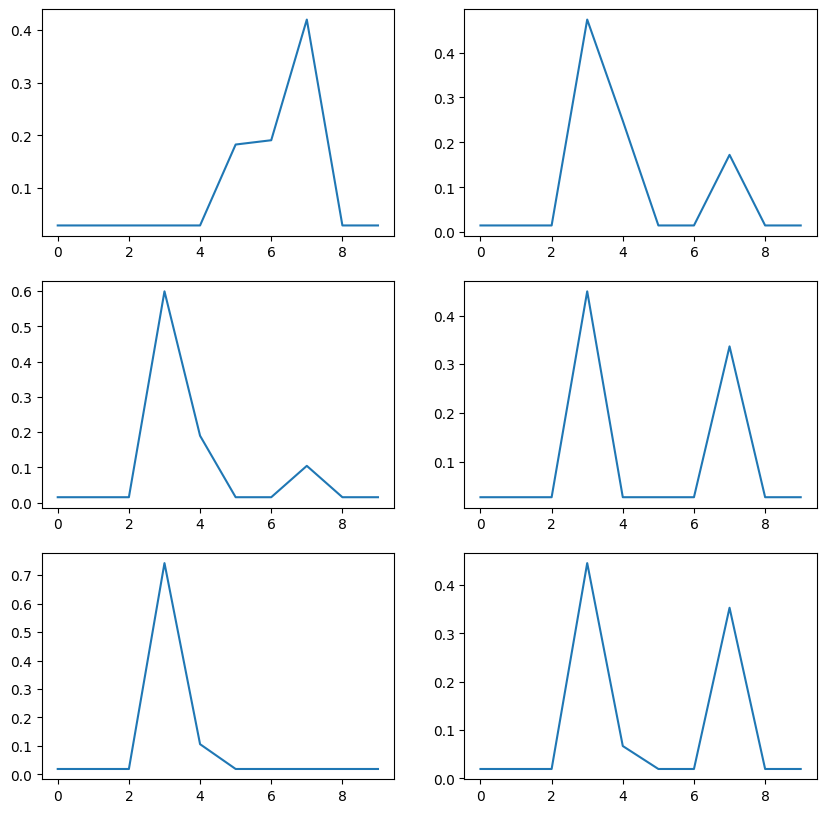

In [35]:
plt.figure(figsize=(10,10))
for i in range(6):
    idx = np.random.randint(0, topics.shape[0])
    plt.subplot(3, 2, i+1)
    plt.plot(topics[idx])

### Ключевые слова

Теперь извлечём ключевые слова для каждой из 20 тем. В свойсте _components_ _ лежит матрица соответствия слов темам. Пройдёмся по каждой из 20 выделенных тем и для каждой возьмём ТОП-20 слов.

По очереди пройдёмся по каждой теме (первое измерение массиа) и выберем ТОП-20 слов, наиболее характерных для этой темы. Потом по индексу слова обратимся к словарю и узнаем, что это за слово.

In [36]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-11:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
состояться, страны, промышленный, вакансий, лежать, упростить, интеллекта, верю, статус, казахстана, ребят

 
Тема 2 :
поиск, энергия, карьерный, предназначить, рекомендация, возможности, предложить, совет, благодарить, контактов, поддержку

 
Тема 3 :
суть, разработать, фильм, хобби, инстаграм, назвать, магазин, задача, главный, логотип, стиль

 
Тема 4 :
решение, продукт, нужно, каждый, вопрос, работа, бизнес, работать, время, человек, компания

 
Тема 5 :
нейросеть, следовать, вариант, слово, казаться, знать, нравиться, голова, изображение, правило, мысль

 
Тема 6 :
интересоваться, регистрация, программы, пятница, языка, департамент, рекомендации, финтех, митапа, доклад, подписаться

 
Тема 7 :
проверять, экспертный, линия, учиться, исключительно, память, месте, сотрудника, подойти, индивидуально, сервисом

 
Тема 8 :
поиск, разработчик, знание, вакансия, резюме, проект, разработка, команда, искать, работа, опыт

 
Тема 9 :
зарабатывать, направление, услуг, книгу, начинать

По полученным ключевым словам можно составить представление о содержании той или иной темы. При этом слова в топиках пересекаются, например:

- слово "поиск" в темах 2 и 8 на первой позиции,
- слово "разработка" в темах 3, 8, 10,
- слово "работа" в 3,4,8 темах,
- слово "услуг" в 8 и 9 темах,
- слово "бизнес" в 4 и 10.

### Типичные статьи

Теперь для каждой темы возьмём по одному документу, который хорошо соответсвует этой теме. Для этого заглянем в массив _topics_.

In [37]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i)
    print(df.iloc[doc_id]["post"])
    print("\n")

Тема  0
С 11 по 13 августа в г.Калуга состоится IX Форум по цифровизации оборонно-промышленного комплекса России #ИТОПК2020.Программа мероприятия доступна на сайте: https://xn--h1aelen.xn--p1ai/На фото совместный стенд RASSE (I-Teco Group) и Security Code.#it #security


Тема  1
Здравствуйте, я в поиске новой карьерной возможности в QA/тестировании и буду признательна за вашу поддержку. Заранее благодарю за все рекомендации контактов, советы или возможности, которые вы можете предложить. Hello, I am looking for a new career opportunity in QA/testing and would appreciate your support. Thank you in advance for all the contact recommendations, tips or opportunities that you can offer.#OpenToWork #QAEngineer #QASpecialist #Tester #ManualTester #Testing #qa #Тестировщик #ТестированиеTelegram: @kris_ozhogEmail: kris94ozhog@gmail.com


Тема  2
Коллеги по бизнесу, а так же читатели Linkedin. Прошу поддержать моего друга в его уже хороших начинаниях :) Подпишитесь на его инстаграм @ddnn.shop . 

Типичные статьи, в целом хорошо согласуются с ключевыми словами, которые мы выделили. Например, первая выделенная тема - про египтологию и археологию. 
 В тоже время, мы видим и очень короткие тексты, например 4 и 14. Это подсказывает дальнейшие шаги. Например:
  - удалить из корпуса текстов очень короткие статьи. Чтобы правильно задать порог отсечения, необходимо построить распределение текстов по длине.   - возможно, ключевыми словами, на которые ориентировался алгоритм, стали названия информационных агентств - РБК и ИТАР-ТАСС. Стоит подумать о том, чтобы добавить эти слова в стоп-лист. 

А ещё вы всегда можете сделать шаг назад и дополнить модель. Например:
- пополнить список стоп-слов (просмотрите внимательно ключевые слова каждой из тем - нет ли там случайных слов?);
- изменить настройки Tf-idF;
- увеличить/уменьшить количество тем;
- обучать LDA чуть дольше;
- заменить LDA на другой алгоритм тематического моделирояни.

# Полезные ссылки

- [Вики](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

- [История о том, как прочитать 120 тысяч анекдотов и не рассмеяться раньше времени](https://habr.com/ru/companies/otus/articles/723306/)

- [Видеоурок "Анализ текстовых данных тематическое моделирование комментариев Вконтакте"](https://www.youtube.com/watch?v=0DnfzQdbwQw)

- [LDA в Sklearn](https://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html)

- [Topic Modeling разными алгоритмами](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

- [Более академическое описание тематического моделировния](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)